In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pandas as pd
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from functools import partial

from plotly.subplots import make_subplots
import statsmodels.api as sm
import scipy.signal as signal

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
def distance_weighted(x,y,mu):
    return np.sum(np.array(mu)*(x-y)**2)

def generate_subsequences(data, window_size, step_size):
    num_points, num_variables = data.shape
    number_subs = int((num_points - window_size)/step_size) + 1  # Number of subsequences

    subsequences = np.zeros((number_subs, window_size, num_variables))

    for i in range(number_subs):
        subsequences[i, :, :] = data[i*step_size:i*step_size+window_size, :]
    return subsequences

def reconstructed_loss(reconstructed_points, initial_points):
    return np.linalg.norm(reconstructed_points - initial_points, ord=2, axis=1)


### Preprocessing

In [3]:
train_data = pd.read_csv('data/swat/SWaT_test.csv')

In [4]:
train_data["Normal/Attack"] = train_data["Normal/Attack"].replace({"Normal": 0, "Attack": 1})

In [5]:
train_data["Normal/Attack"].value_counts()
df_np_label = train_data.drop([" Timestamp", "Normal/Attack"], axis=1).values

In [6]:
#data_without_cte = train_data.drop(columns = constant_channel_names + ["Unnamed: 0","Normal/Attack"]).values
#df_np_label_reduced = data_without_cte[::, 1:]
data_np = train_data.drop(columns = ["Unnamed: 0","Normal/Attack", " Timestamp"]).values

In [7]:
scaler = StandardScaler()

In [8]:
data_np = scaler.fit_transform(data_np)

In [11]:
# Create a PCA instance
n_components_analysis = 20
pca = PCA(n_components = n_components_analysis)

# Fit the data and transform it
data_pca = pca.fit_transform(data_np)

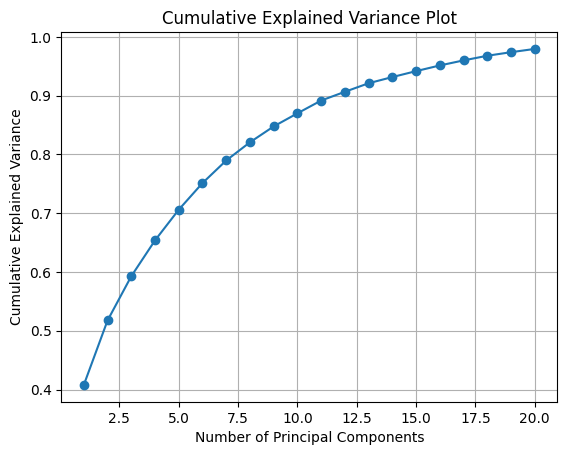

[0.40783483 0.51749147 0.5927148  0.65373156 0.70592446 0.75118774
 0.78960598 0.82056035 0.84753422 0.86981606 0.89157828 0.9064483
 0.92098476 0.93151042 0.94159047 0.95125386 0.95984561 0.96774067
 0.97381102 0.97937024]


In [12]:
# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()
print(cumulative_explained_variance)

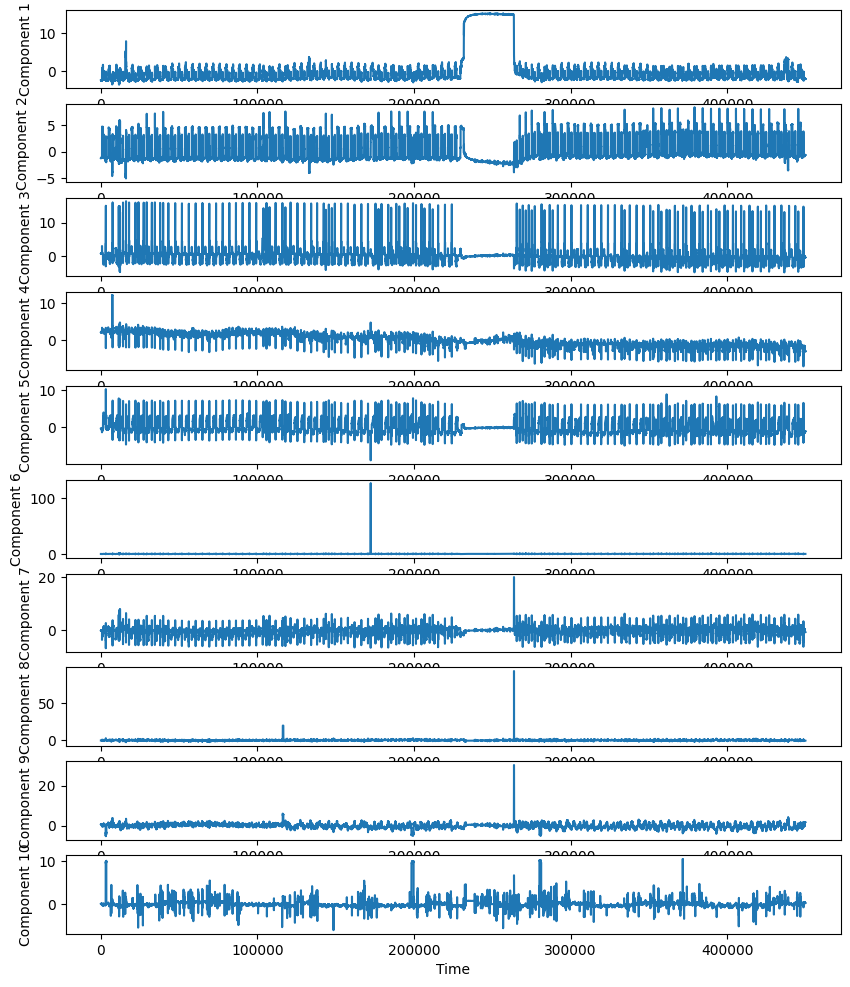

In [38]:

# Plot the first 5 components in 5 subplots
fig, axes = plt.subplots(10, 1, figsize=(10, 12))

for i in range(10):
    axes[i].plot(data_pca[:, i])
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

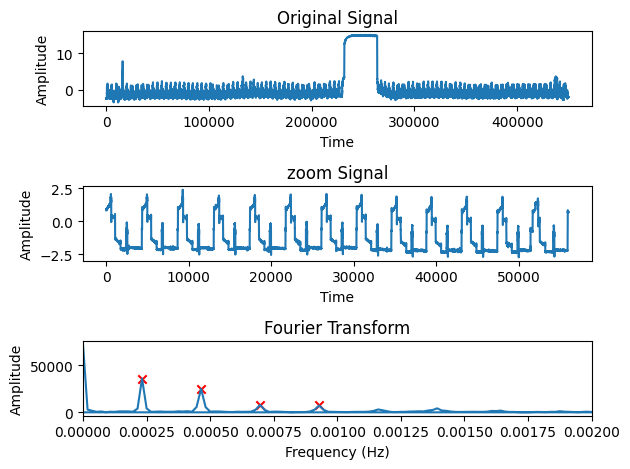

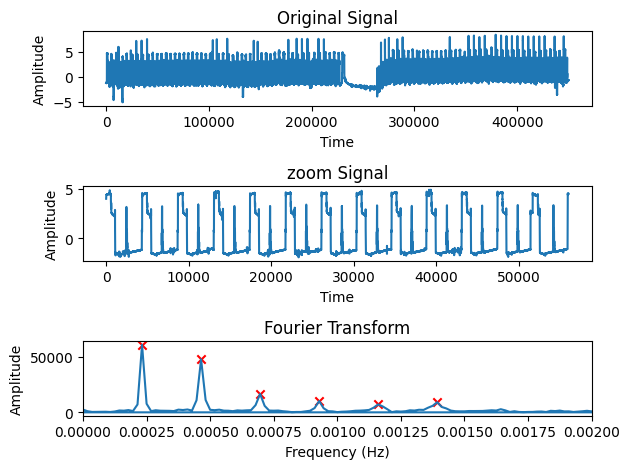

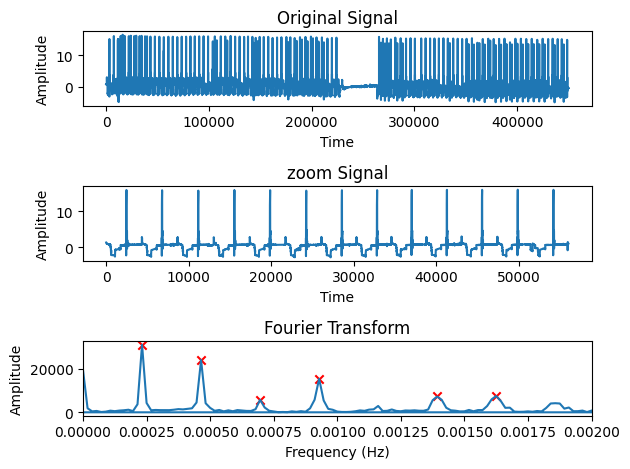

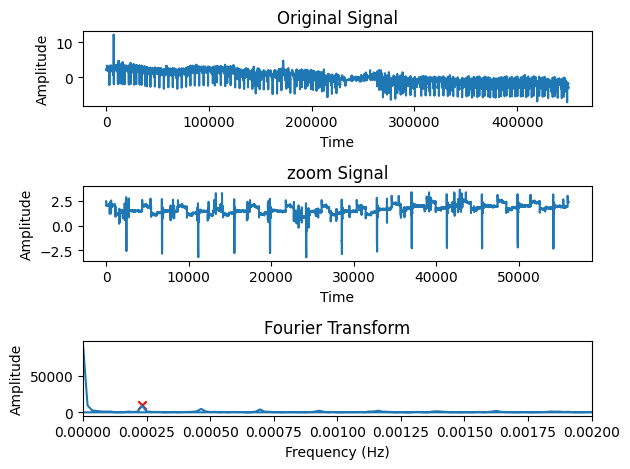

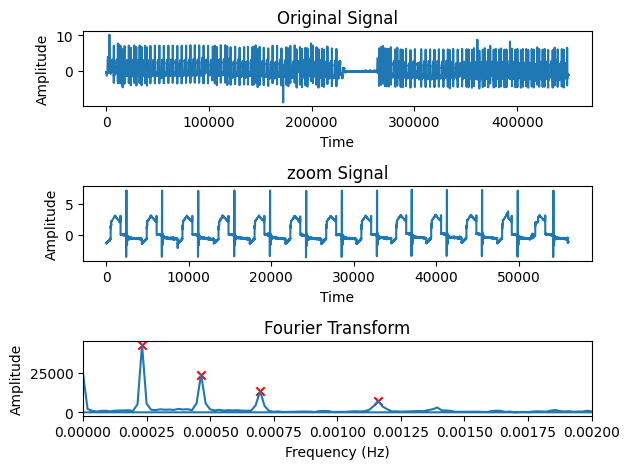

In [21]:
from scipy.signal import find_peaks
n_components = 5
periodicity = []
for i in range(n_components):
    signal_periodic = data_pca[45000:101000, i]
    fourier_transform = np.fft.fft(signal_periodic)
    frequencies = np.fft.fftfreq(len(signal_periodic), 1)

    peaks, _ = find_peaks(np.abs(fourier_transform), height=0.5e4)
    periodicity.append(1/frequencies[peaks[:3]])
    plt.subplot(3, 1, 1)
    plt.plot( data_pca[:, i])
    plt.title('Original Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot( signal_periodic)
    plt.title('zoom Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.plot(frequencies, np.abs(fourier_transform))
    plt.scatter(frequencies[peaks], np.abs(fourier_transform)[peaks], color='red', marker='x', label='Local Maxima')

    plt.title('Fourier Transform')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0,0.002)
    plt.tight_layout()
    plt.show()


In [22]:
main_periodicity = periodicity[0][0]
print("Main periodicity in seconds", main_periodicity)
downsampling_rate = int(main_periodicity/40)

Main periodicity in seconds 4307.692307692308


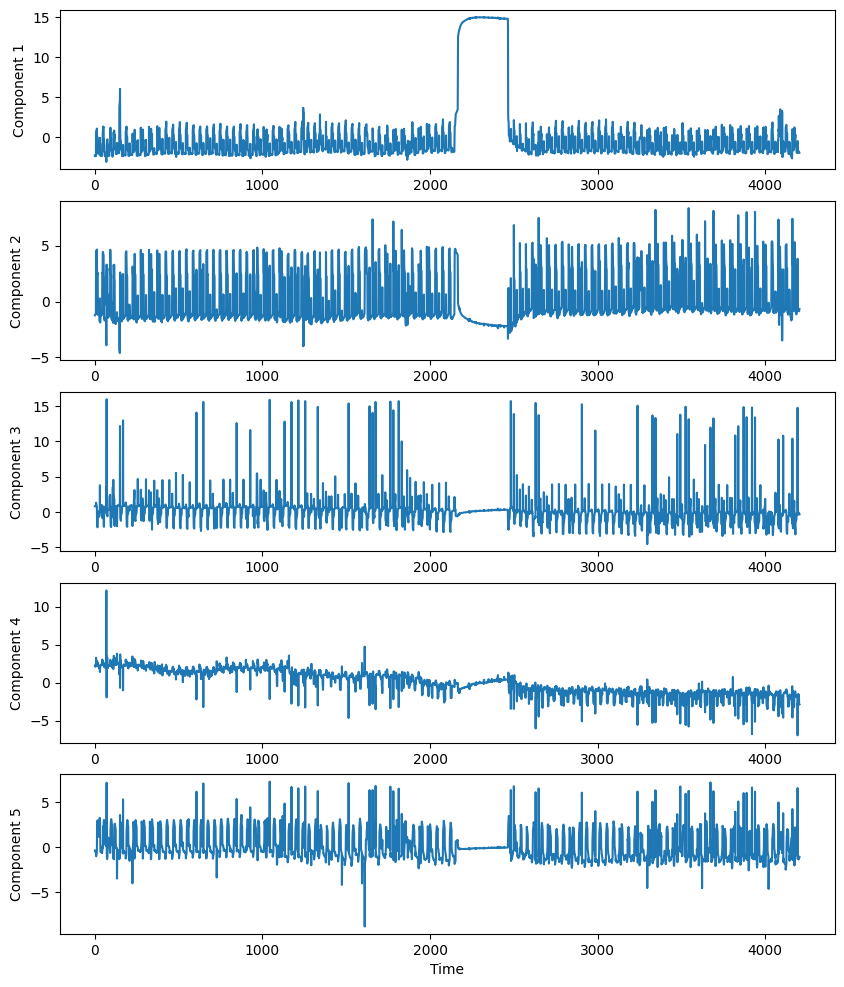

In [24]:
### Downsample the data 

# Plot the first 5 components in 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for i in range(5):
    axes[i].plot(data_pca[::downsampling_rate, i])
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

### Anomaly detection

#### Generate subsequences for shapes and amplitudes

In [25]:
data_pca_reduced = data_pca[:,:n_components]

window_size = int(main_periodicity/downsampling_rate)

stride =int(window_size/5)
sequences = generate_subsequences(data_pca_reduced[::downsampling_rate], window_size, stride)
label_sequences = generate_subsequences(train_data["Normal/Attack"].values.reshape(-1,1)[::downsampling_rate], window_size, stride)

print("window size = ", window_size)
print("stride = ", stride)

window size =  40
stride =  8


In [26]:
sequences_acf = np.zeros_like(sequences)

In [27]:
sequences_copy = sequences.copy()

for i in range(sequences_copy.shape[0]):
    for j in range(sequences_copy.shape[2]):

        # check if all values are the same
        if np.all(sequences_copy[i, :, j] == sequences_copy[i, 0, j]):
            sequences_copy[i, 0, j] += 0.0001
            # print("warning: constant timeseries")
            
        sequences_acf[i, :, j] = sm.tsa.acf(
            sequences_copy[i, :, j], nlags=len(sequences_copy[i, :, j]) - 1
        )

# sequences_acf[np.isnan(sequences_acf)] = sequences[np.isnan(sequences_acf)]

In [28]:
data_for_clustering = sequences.reshape(sequences.shape[0], -1)
data_for_clustering_shapes = sequences_acf.reshape(sequences_acf.shape[0], -1)

#### Fuzzy C-Means on amplitude using naive mu

In [29]:
mu = [1 / data_for_clustering.shape[1] for i in range(data_for_clustering.shape[1])]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering.T,
    3, # N cluster
    2, # fuzzy coef
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [30]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering)


In [31]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

#### Fuzzy C-means on shapes with ACF

In [33]:
mu = [
    1 / data_for_clustering_shapes.shape[1]
    for i in range(data_for_clustering_shapes.shape[1])
]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering_shapes.T,
    3,  # N cluster
    2,  # jsp
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [34]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering_shapes)

In [35]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [36]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

### Optimization

In [25]:
from utils import optimizer as opt

N_cluster = 2
model = "amplitude"

if model == "amplitude":
    data_for_clustering_opt = data_for_clustering

    data_for_clustering_opt = data_np[::100]

else:
    data_for_clustering_opt = data_for_clustering_shapes

algorithm_param = {
    "max_num_iteration": 100,
    "population_size": 30,
    "mutation_probability": 0.1,
    "elit_ratio": 0.05,
    "crossover_probability": 1,
    "parents_portion": 0.3,
    "crossover_type": "uniform",
    "max_iteration_without_improv": None,
}

In [26]:
optimizer = opt(
    N_cluster=N_cluster,
    data=data_for_clustering_opt,
    window_size=window_size,
    ga_opt_parameters=algorithm_param,
)

 The best solution found:                                                                           
 [0.34098073]

 Objective function:
 649303.0433634571


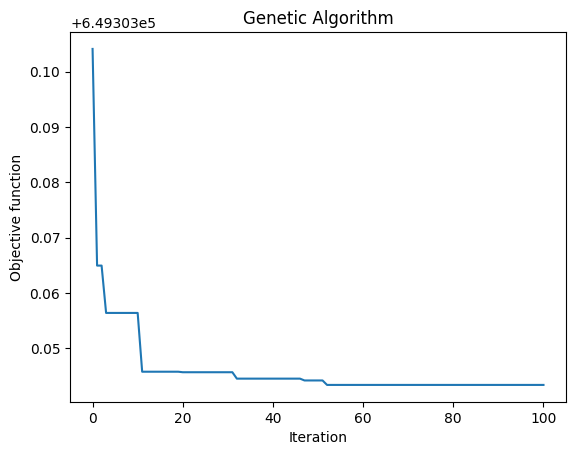

In [27]:
optimizer.run_ga()

In [28]:
optimizer.run_pso(max_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
convergence_ga = optimizer.convergence_ga
solution_ga = optimizer.solution_ga
fitness_pso = optimizer.fitness_pso
solution_pso = optimizer.solution_pso

print(f"ga: {convergence_ga[-1]}, pso : {fitness_pso}")

ga: 512067.6408043953, pso : 512048.0291733195


In [ ]:
def normalize_lambda(lambdas):
    return lambdas / np.sum(lambdas)

In [ ]:
print(f"ga: {normalize_lambda(solution_ga['variable'])}, \n pso : {normalize_lambda(solution_pso)}")

ga: [0.17608877 0.40849588 0.01883241 0.00876187 0.38782107], 
 pso : [1.39736306e-01 4.72504796e-01 4.06586320e-04 0.00000000e+00
 3.87352311e-01]


In [ ]:
print(len(optimizer.dict_opt_save), len(optimizer.dict_opt_save_pso))

2030 2020


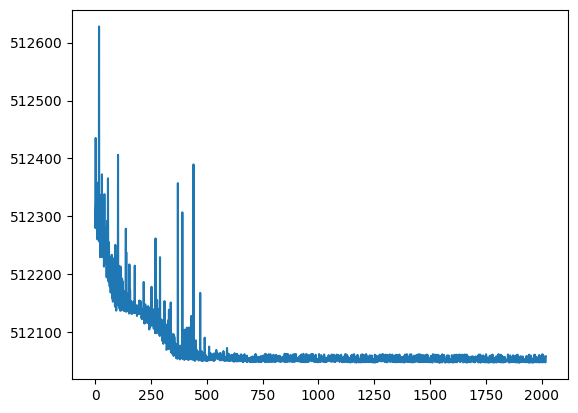

In [ ]:
plt.plot([optimizer.dict_opt_save_pso[i]["loss_sum"] for i in range(0, len(optimizer.dict_opt_save_pso))])

In [ ]:
import pickle 

In [ ]:
with open(f'{N_cluster}_dict_opt_save_NOPCA.pkl', 'wb') as f:
    pickle.dump(optimizer.dict_opt_save, f)

In [ ]:
with open(f'{N_cluster}_dict_opt_save_pso_NOPCA.pkl', 'wb') as f:
    pickle.dump(optimizer.dict_opt_save_pso, f)

In [ ]:
with open(f'{N_cluster}_dict_opt_save_pso.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
        
with open(f'{N_cluster}_dict_opt_save_pso.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [1]:
# optimizer.dict_opt_save
# optimizer.dict_opt_save_pso

### Use the optimization result to run the reconstruction loss

In [101]:
# use stored mu 

# N = 2, amplitude : mu = [0.21776668 0.84530544 0.00231269 0.01345887 0.64944092]
# N = 3, amplitude : mu = 
# N = 2, shape : mu = 
# N = 3, shape : mu = 

opt_mu = solution_ga["variable"] # solution_pso

In [102]:
win_len = data_for_clustering_opt.shape[1] // len(opt_mu)

opt_mu = opt_mu / opt_mu.sum()  # normalize the coefficients
opt_mu = np.repeat(opt_mu, win_len)

In [103]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_for_clustering_opt.T,
    N_cluster, # N cluster
    2, #
    metric=partial(distance_weighted, mu=opt_mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
opt_reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [104]:
opt_loss = reconstructed_loss(opt_reconstructed_points, data_for_clustering_opt)

In [105]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(opt_loss)), y=opt_loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=opt_loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

### Metric : combining the subsequences to calculate a score on the og TS

In [106]:
def upscale_signal(subsequences, original_size, stride, window_length, operator=np.maximum):
    upscaled_signal = np.zeros(original_size)  # Initialize upscaled signal array

    for i, subsequence in enumerate(subsequences):
        start_index = i * stride
        end_index = start_index + window_length
        upscaled_signal[start_index:end_index] = operator(upscaled_signal[start_index:end_index], subsequence)

    return upscaled_signal[upscaled_signal > 0]

data_pca_reduced_downsampled = data_pca_reduced[::downsampling_rate].copy()
total_loss = upscale_signal(opt_loss, data_pca_reduced_downsampled.shape[0], stride, window_size, operator=np.maximum)

In [107]:
fig = go.Figure()

temp = np.where(train_data["Normal/Attack"][::downsampling_rate].values == 1)[0]

fig.add_trace(go.Scatter(x=np.arange(len(total_loss)), y=total_loss, mode="lines", name="opt Loss"))
fig.add_trace(
    go.Scatter(
        x=temp, y=total_loss[temp], mode="markers", name="Attack"
    )
)

fig